# Facial Recognition with Siamese Network

## Setup

In [1]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import cv2
import os
import uuid
import random
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, Dense, Dropout, BatchNormalization, DepthwiseConv2D
from tensorflow.keras.metrics import Precision, Recall

In [2]:
# Verify GPU availability
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    for device in gpu_devices:
        print(f"GPU found: {device.name}")
else:
    print("No GPU found.")

GPU found: /physical_device:GPU:0


2024-05-13 21:25:25.018567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-13 21:25:25.168500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-13 21:25:25.168552: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
#Create paths and directories
base_dir = 'model_data'
sub_dirs = ['user_positive_images', 'preloaded_negative_images', 'user_anchor_images', 'input_image']
for sub_dir in sub_dirs:
    path = os.path.join(base_dir, sub_dir)
    os.makedirs(path, exist_ok=True)

In [4]:
# Extract dataset from 'Labeled Faces in the Wild (LFW) database'
# Can be found at this link: https://vis-www.cs.umass.edu/lfw/#download

os.system('tar -xf lfw.tgz')

0

In [5]:
# Relocate LFW dataset images to 'preloaded_negative_images folder' for training
for folder in os.listdir('lfw'):
    for image in os.listdir(os.path.join('lfw', folder)):
        source_path = os.path.join('lfw', folder, image)
        target_path = os.path.join(base_dir, 'preloaded_negative_images', image)
        os.rename(source_path, target_path)

## Collect Anchor & Positive Pictures From User

In [6]:
# Function to use webcam and openCV to open the webcam and capture pictures of anchor and positive
# Total of 200 captured
def capture_images(image_type, sub_dir):
    cap_device = cv2.VideoCapture(-1)
    cap_device.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'))
    while cap_device.isOpened():
        ret, frame = cap_device.read()
        frame_cropped = frame[120:520, 200:600]

        if cv2.waitKey(1) & 0xFF == ord(image_type[0]):
            img_path = os.path.join(base_dir, sub_dir, f'{uuid.uuid4()}.jpg')
            cv2.imwrite(img_path, frame_cropped)

        cv2.imshow("Capture", frame_cropped)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap_device.release()
    cv2.destroyAllWindows()

In [7]:
# Capture anchor and positive images, using 'a' key for anchor images, and 'p' key for positive images
capture_images('anchor', 'user_anchor_images')
capture_images('positive', 'user_positive_images')

## Prepare & Pre-process Images

In [8]:
# Function to load and limit the number of files from a specified directory
def load_dataset(file_pattern, limit):
    """
    Loads a dataset based on the file pattern and limits the number of files.
    
    Args:
        file_pattern (str): Glob pattern to match the files.
        limit (int): Maximum number of files to load.
    
    Returns:
        tf.data.Dataset: A TensorFlow dataset containing file paths.
    """
    dataset = tf.data.Dataset.list_files(file_pattern).take(limit)
    return dataset

# Function to preprocess images from file paths
def preprocess_image(file_path):
    """
    Reads an image from a file, decodes it, resizes it, and normalizes the pixel values.
    
    Args:
        file_path (str): Path to the image file.
    
    Returns:
        tf.Tensor: The processed image tensor.
    """
    image = tf.io.read_file(file_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [100, 100])
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Function to pair datasets with labels for the Siamese network
def create_pairs(anchor_dataset, positive_dataset, label):
    """
    Creates paired datasets for the Siamese network, each pair with a label.
    
    Args:
        anchor_dataset (tf.data.Dataset): Dataset of anchor images.
        positive_dataset (tf.data.Dataset): Dataset of positive or negative images.
        label (int): Label indicating positive (1) or negative (0) pair.
    
    Returns:
        tf.data.Dataset: A dataset of pairs with labels.
    """
    return tf.data.Dataset.zip((anchor_dataset, positive_dataset, tf.data.Dataset.from_tensors(label).repeat()))

# Paths for datasets
anchor_path = f'{base_dir}/user_anchor_images/*.jpg'
positive_path = f'{base_dir}/user_positive_images/*.jpg'
negative_path = f'{base_dir}/preloaded_negative_images/*.jpg'

# Load datasets
anchor_data = load_dataset(anchor_path, 200)
positive_data = load_dataset(positive_path, 200)
negative_data = load_dataset(negative_path, 200)

# Pair datasets with appropriate labels
positive_pairs = create_pairs(anchor_data, positive_data, 1)
negative_pairs = create_pairs(anchor_data, negative_data, 0)
full_dataset = positive_pairs.concatenate(negative_pairs)

2024-05-13 21:25:32.066841: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 21:25:32.070126: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-13 21:25:32.070185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-13 21:25:32.070214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

## Create Train & Test Model

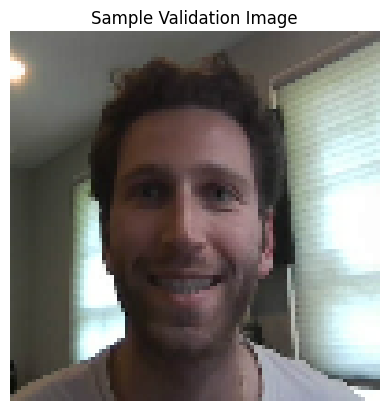

In [9]:
# Function to preprocess pairs for training/testing
def preprocess_pairs(anchor, validation, label):
    """
    Preprocesses each pair of images in the dataset.
    
    Args:
        anchor (str): File path to the anchor image.
        validation (str): File path to the validation image.
        label (int): Label of the pair.
    
    Returns:
        tuple: Tuple of preprocessed anchor image, validation image, and label.
    """
    return preprocess_image(anchor), preprocess_image(validation), label

# Apply preprocessing to the full dataset
full_dataset = full_dataset.map(preprocess_pairs)
full_dataset = full_dataset.cache().shuffle(buffer_size=1024)

# Determine the size for training and testing
dataset_size = sum(1 for _ in full_dataset)
train_size = int(dataset_size * 0.7)
test_size = dataset_size - train_size

# Split into training and testing datasets
train_data = full_dataset.take(train_size).batch(16).prefetch(tf.data.experimental.AUTOTUNE)
test_data = full_dataset.skip(train_size).take(test_size).batch(16).prefetch(tf.data.experimental.AUTOTUNE)

# Display a sample from the dataset
for sample in train_data.take(1):
    plt.imshow(sample[0][1])  # Show a validation image from the first batch
    plt.title('Sample Validation Image')
    plt.axis('off')
    plt.show()

## Create Embedded Layer Model

In [10]:
# Build Embedded Layer
def embedded_model_v2():
    # Input layer
    input_layer = Input(shape=(100, 100, 3), name='input_image')
    
    # First convolutional block
    conv1 = Conv2D(128, (7, 7), activation='relu', padding='same')(input_layer)
    norm1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2), padding='same')(norm1)

    # Second convolutional block
    conv2 = Conv2D(256, (5, 5), activation='relu', padding='same')(pool1)
    norm2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2), padding='same')(norm2)

    # Third convolutional block
    conv3 = Conv2D(292, (3, 3), activation='relu', padding='same')(pool2)
    norm3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2), padding='same')(norm3)

    # Fourth convolutional block
    conv4 = Conv2D(292, (3, 3), activation='relu', padding='same')(pool3)
    norm4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D((2, 2), padding='same')(norm4)

    # Flatten layer for transitioning to fully connected layers
    flat_layer = Flatten()(pool4)

    # First fully connected (dense) layer
    dense1 = Dense(2048, activation='relu')(flat_layer)
    drop1 = Dropout(0.5)(dense1)

    # Second fully connected (dense) layer
    dense2 = Dense(2048, activation='relu')(drop1)
    drop2 = Dropout(0.5)(dense2)

    # Final dense layer for output
    output_layer = Dense(4096, activation='sigmoid')(drop2)

    # Create model
    model = Model(inputs=input_layer, outputs=output_layer, name='embedded_model_v2')
    return model

embedded_model = embedded_model_v2()
embedded_model.summary()

Model: "embedded_model_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 128)     18944     
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 256)       819456    
                                                                 
 batch_normalization_1 (Batc  (None, 50, 50, 256)

In [11]:
# Define the distance layer for the Siamese network
class EmbeddingDistance(Layer):
    """
    This class calculates the L1 distance between embedding vectors.
    It extends TensorFlow's Layer class for integration in a model.
    """
    def __init__(self, **kwargs):
        super(EmbeddingDistance, self).__init__(**kwargs)
    
    def call(self, emb1, emb2):
        # Compute absolute difference between embeddings
        return tf.math.abs(emb1 - emb2)

In [12]:
# Construct the Siamese Neural Network
def build_siamese_network():
    """
    Function to build a Siamese network that compares two input images.
    Returns a compiled model.
    """
    # Define the inputs for the two images to compare
    anchor_input = Input(name='anchor_img', shape=(100, 100, 3))
    compare_input = Input(name='compare_img', shape=(100, 100, 3))
    
    # Instantiate the distance layer
    distance_layer = EmbeddingDistance(name='compare_layer')
    # Apply the embedding model to both inputs
    distances = distance_layer(embedded_model(anchor_input), embedded_model(compare_input))
    
    # Output layer that performs classification
    output_layer = Dense(1, activation='sigmoid')(distances)
    
    # Create the Siamese network model
    siamese_network = Model(inputs=[anchor_input, compare_input], outputs=output_layer, name='Siamese_Network')
    return siamese_network

# Initialize the Siamese network model and print the summary
siamese_network_instance = build_siamese_network()
siamese_network_instance.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_img (InputLayer)        [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 compare_img (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedded_model_v2 (Functional)  (None, 4096)        44176888    ['anchor_img[0][0]',             
                                                                  'compare_img[0][0]

## Train Model

In [13]:
# Setup optimizer and loss function for model training
# Setup optimizer and loss function for model training
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_function = tf.keras.losses.BinaryCrossentropy()

# Define the training operation
@tf.function
def execute_training_step(batch_data):
    """
    Performs a single training step including forward pass, loss calculation,
    and backward pass for gradient updates.
    """
    with tf.GradientTape() as tape:
        # Unpack the data
        inputs, labels = batch_data[:2], batch_data[2]
        
        # Perform a forward pass through the network
        predictions = siamese_network_instance(inputs, training=True)
        
        # Compute the loss value for this batch
        loss_value = loss_function(labels, predictions)

    # Retrieve the gradients of the trainable variables with respect to the loss
    gradients = tape.gradient(loss_value, siamese_network_instance.trainable_variables)
    
    # Apply the gradients to the optimizer
    optimizer.apply_gradients(zip(gradients, siamese_network_instance.trainable_variables))
    
    # Return the loss value and predictions as tensors
    return loss_value, predictions

def run_training_loop(training_data, number_of_epochs):
    """
    Runs the training loop over the specified number of epochs.
    """
    # Metrics to monitor
    recall_metric = tf.keras.metrics.Recall()
    precision_metric = tf.keras.metrics.Precision()
    accuracy_metric = tf.keras.metrics.BinaryAccuracy()
    #f1_score_metric = tf.metrics.F1Score(num_classes=1, threshold=0.5)

    # Iterate through epochs
    for epoch in range(1, number_of_epochs + 1):
        print(f'\n Epoch {epoch}/{number_of_epochs}')
        progress_bar = tf.keras.utils.Progbar(target=len(training_data))
        
        # Iterate over the batches of the dataset
        for index, batch in enumerate(training_data):
            # Perform a training step
            loss, predictions = execute_training_step(batch)
            
            # Update metrics with current batch results
            recall_metric.update_state(batch[2], predictions)
            precision_metric.update_state(batch[2], predictions)
            accuracy_metric.update_state(batch[2], predictions)
            #f1_score_metric.update_state(batch[2], predictions)
            
            # Update progress bar
            progress_bar.update(index + 1)
        
        # Output metrics at the end of the epoch
        print(f"Loss: {loss.numpy()}, Recall: {recall_metric.result().numpy()}, Precision: {precision_metric.result().numpy()}, Accuracy: {accuracy_metric.result().numpy()}")

        # Reset the metrics at the end of each epoch
        recall_metric.reset_states()
        precision_metric.reset_states()
        accuracy_metric.reset_states()
        #f1_score_metric.reset_states()

# Initialize and run the training loop
run_training_loop(train_data, 50)


 Epoch 1/50


2024-05-13 21:25:34.283750: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2024-05-13 21:25:35.862984: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-05-13 21:25:35.863028: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-05-13 21:25:36.065937: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-13 21:25:36.517740: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of 

18/18 [==============================] - 7s 167ms/step
Loss: 0.20648856461048126, Recall: 0.800000011920929, Precision: 0.6946107745170593, Accuracy: 0.7222222089767456

 Epoch 2/50
18/18 [==============================] - 2s 115ms/step
Loss: 0.04684269428253174, Recall: 1.0, Precision: 0.9718309640884399, Accuracy: 0.9861111044883728

 Epoch 3/50
18/18 [==============================] - 2s 116ms/step
Loss: 0.002092917449772358, Recall: 1.0, Precision: 1.0, Accuracy: 1.0

 Epoch 4/50
18/18 [==============================] - 2s 116ms/step
Loss: 0.002893146127462387, Recall: 1.0, Precision: 0.9929078221321106, Accuracy: 0.9965277910232544

 Epoch 5/50
18/18 [==============================] - 2s 116ms/step
Loss: 0.0034975018352270126, Recall: 1.0, Precision: 1.0, Accuracy: 1.0

 Epoch 6/50
18/18 [==============================] - 2s 116ms/step
Loss: 0.0009953670669347048, Recall: 1.0, Precision: 1.0, Accuracy: 1.0

 Epoch 7/50
18/18 [==============================] - 2s 117ms/step
Loss: 0

## Evaluate Model & Visualize Results

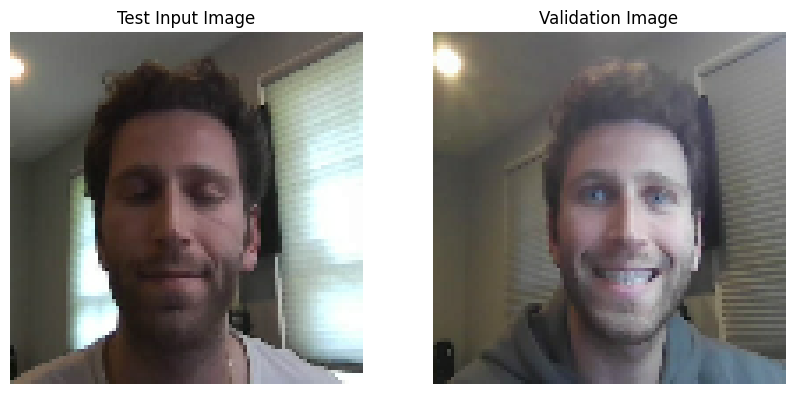

Model saved at siameseModel.h5
Loaded model details:
Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_img (InputLayer)        [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 compare_img (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedded_model_v2 (Functional)  (None, 4096)        44176888    ['anchor_img[0][0]',             
                               

In [30]:
# Evaluation and Visualization of the Siamese Model

# Fetch a single batch of test data
test_batch = test_data.as_numpy_iterator().next()
test_input, test_val, y_true = test_batch

# Visualizing the input and validation images from the test batch
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 8))  # Create a figure with a 1x2 grid of Axes

# Display the first test input image
axes[0].imshow(test_input[0])
axes[0].set_title("Test Input Image")
axes[0].axis('off')  # Hide axes ticks

# Display the first validation image
axes[1].imshow(test_val[0])
axes[1].set_title("Validation Image")
axes[1].axis('off')

plt.show()  # Display the figure

# Model Persistence: Save and Load Operations

# Save the trained Siamese model
model_path = 'siameseModel.h5'
siamese_network_instance.save(model_path)
print(f"Model saved at {model_path}")

# Load the saved model to verify it loads correctly and compile it with the custom objects used
from tensorflow.keras.models import load_model

loaded_model = load_model(model_path, custom_objects={'EmbeddingDistance': EmbeddingDistance})
print("Loaded model details:")
loaded_model.summary()

# Make a prediction with the loaded model to confirm it's working as expected
sample_prediction = loaded_model.predict([test_input, test_val])
print("Sample prediction from loaded model:", sample_prediction)


## Model Verification

In [26]:
def authenticate_user(model, det_threshold=0.85, verif_threshold=0.7):
    """
    Authenticates a user by comparing an input image with a set of positive sample images,
    using the provided Siamese model that outputs a similarity score for each image pair.
    
    Args:
        model (tf.keras.Model): The trained Siamese neural network model used for prediction.
        det_threshold (float): The threshold above which a prediction is considered a match,
                               indicating high similarity between the input and the sample image.
        verif_threshold (float): The ratio of matches needed to consider the authentication successful.
        
    Returns:
        tuple: Contains the list of similarity scores, a boolean indicating if the user is verified,
               and statistical measures (average, minimum, maximum similarity scores) of the session.     
               
    This function operates by loading the designated input image and iterating over a directory
    of positive samples. For each sample, the model predicts a similarity score reflecting the likelihood
    that the input image matches the sample. Scores above the detection threshold (det_threshold) are
    considered matches. The number of matches is then compared against the total number of samples to
    determine if the user is authenticated based on the verification threshold (verif_threshold).

    Additionally, the function computes statistical measures such as average, minimum, and maximum
    similarity scores, which provide insights into the overall session's authentication outcomes.
    """
    
    input_path = os.path.join('model_data', 'input_image', 'current.jpg')
    input_image = preprocess_image(input_path)

    positive_dir = os.path.join('model_data', 'user_positive_images')
    image_files = os.listdir(positive_dir)
    scores = []

    for filename in image_files:
        val_image_path = os.path.join(positive_dir, filename)
        val_image = preprocess_image(val_image_path)

        # Model predicts similarity score directly
        score = model.predict([input_image[np.newaxis, ...], val_image[np.newaxis, ...]])
        scores.append(score[0][0])  # Assuming score is returned in this shape

    detection_count = np.count_nonzero(np.array(scores) > det_threshold)
    verification_rate = detection_count / len(image_files)
    is_authenticated = verification_rate > verif_threshold

    # Calculate statistics
    avg_score = np.mean(scores)
    min_score = np.min(scores)
    max_score = np.max(scores)

    return scores, is_authenticated, avg_score, min_score, max_score

In [28]:
def perform_real_time_authentication():
    """
    Performs real-time authentication by capturing video frames, applying preprocessing,
    and using a trained model to verify identity based on similarity scores.
    """
    camera = cv2.VideoCapture(0)
    camera.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'))

    try:
        while camera.isOpened():
            success, frame = camera.read()
            if not success:
                print("Failed to capture video")
                break

            # Define the region of interest (ROI)
            roi = frame[120:520, 200:600]
            cv2.imshow('Verify Your Identity', roi)

            if cv2.waitKey(1) & 0xFF == ord('v'):
                cv2.imwrite(os.path.join('model_data', 'input_image', 'current.jpg'), roi)
                scores, verified, avg_score, min_score, max_score = authenticate_user(loaded_model)
                print("Recognized!" if verified else "Recognition Failed")
                #print(f"Similarity Scores: {['{:.3f}'.format(score) for score in scores]}")  # Display formatted scores
                print(f"Average L1 Distance: {avg_score:.3f}, Min: {min_score:.3f}, Max: {max_score:.3f}")

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    finally:
        camera.release
        cv2.destroyAllWindows()

perform_real_time_authentication()


Recognized!
Average L1 Distance: 0.988, Min: 0.979, Max: 0.994
Recognition Failed
Average L1 Distance: 0.002, Min: 0.000, Max: 0.004
Recognition Failed
Average L1 Distance: 0.545, Min: 0.377, Max: 0.698
Recognized!
Average L1 Distance: 0.987, Min: 0.979, Max: 0.992


Attempt 1: Original user smiling
Attempt 2: Printed picture of a person
Attempt 3: Different user smiling
Attempt 4: Original user exibiting different facial expression